In [187]:
import os
from scipy.io import loadmat
from PIL import Image
import numpy as np
import glob
import json

In [189]:
# Inspired from https://github.com/ecekt/eyegaze/blob/951f24d028fabca10cf329cd4c505a67c7377e6f/gaze.py#L16

def ivt_mod(coords, freq=240, min_dist=20, v_threshold=10):
    """
    Detects fixations from a series of raw gaze points (x,y) captured at particular frequency (freq) using the 
    velocity thresholding (v_threshold) method.
    
    Arguments:
        coords      - coordinates (x,y) of gaze point on image
        freq        - frequency at which gaze points were captured (depends on the instrument used)
        min_dist    - minimum pixel distance between each fixation. If fixations lie closer than min_dist, they
                      are merged into a single fixation
        v_threshold - each gaze point having lesser velocity than v_threshold is considered as part of a fixation
    
    Returns:
        fixation - list of fixation coords [fy,fx]
        duration - list of durations for each fixation in ms
        
    """
    coords = np.array([c for c in coords if c[0] > 0 and c[1] > 0]) # removing ineligible gaze points
    x, y = coords[:,0], coords[:,1]
    
    # taking the index at which each gaze point was recorded as time
    times = np.array([ t for t in range(len(x)) ]) 

    difX = []
    difY = []
    tdif = []

    for i in range(len(x) - 1):
        difX.append(x[i+1] - x[i])
        difY.append(y[i+1] - y[i])
        tdif.append(times[i+1] - times[i])

    dif = np.sqrt(np.power(difX,2) + np.power(difY,2)) #in pix
    velocity = dif / tdif
    
    # First pass: Applying velocity thresholding to identify fixations
    # All of the fixation clusters are identified and then their centroid is considered as the fixation point
    fixs = []
    durs= []
    fs = []
    fx, fy, t0, r = x[0], y[0], 0, 0
    # print(f'starting from: ({fx:.2f}, {fy:.2f}) at t = {t0}')
    for i, v in enumerate(velocity):
        #print(f'\ni: {i} v: {v:.2f}')
        if v < v_threshold:
            # fixation
            # print(f'({x[i]:.2f}, {y[i]:.2f}) is a fixation',end=" | ")
            if r == 0:
                t0 = times[i]
            fx = (fx*r + x[i])/(r+1)
            fy = (fy*r + y[i])/(r+1)
            r += 1
            # print(f'after averaging: ({fx:.2f}, {fy:.2f}) r = {r}')
        else:
            # rint(f'({x[i]:.2f}, {y[i]:.2f}) is not a fixation')
            t1 = times[i]
            dur = t1 - t0
            if dur > 5:
                fixs.append([fy, fx])
                durs.append(dur)
                # print(f'appending fixation: ({fx:.2f}, {fy:.2f}) with duration: {dur:.2f}')
            fx, fy, t0, r = x[i], y[i], times[i], 0
    
    if len(fixs) == 0:
        return [], []
    # print(f'After first pass:\nfixs: {fixs}\ndurs: {durs}')
    # Second pass: Iterating through fixations and merging the fixations that are too close
    fixation = []
    duration = []
    fixy, fixx = fixs[0]
    # print(f'\nstarting from: ({fixx:.2f}, {fixy:.2f})')
    dur = 0
    r = 1
    for (fy, fx), t in zip(fixs, durs):
        # print(f'\nchecking ({fx:.2f}, {fy:.2f}) with dur = {t}')
        if abs(fixy - fy) < min_dist and abs(fixx - fx) < min_dist:
            # print('too close | ',end='')
            fixx = (fixx*r + fx)/(r+1)
            fixy = (fixy*r + fy)/(r+1)
            dur += t
            r += 1
            # print(f'after merging: ({fixx:.2f}, {fixy:.2f}) dur = {t}. r= {r}')
        else:
            if r != 1:
                # print(f'appending merged fixation: ({fixx:.2f}, {fixy:.2f}) with dur = {dur}')
                fixation.append([round(fixy,2), round(fixx,2)])
                duration.append(dur)
                
            # print(f'({fx:.2f}, {fy:.2f}) is not close to anyone, hence merging')
            fixation.append([round(fy, 2), round(fx,2)])
            duration.append(t)    
            
            fixy, fixx = fy, fx
            dur = 0
            r = 1
            
    if r == 1:
        fixation.append(fixs[-1])
        duration.append(durs[-1])
    
    duration = [round((float(t)/freq)*1000,2) for t in duration] # changing duration in ms
    return fixation, duration

In [2]:
root_dir = 'DATA/DATA/'
persons = [p for p in os.listdir(root_dir) if not (p.endswith('.mat') or p.endswith('.data') or p == '.DS_Store') ]

In [3]:
view_dict = {p: os.listdir(os.path.join(root_dir, p)) for p in persons} 
# view_dict = {person : [list of viewings (.mat files) by this person]}

In [182]:
im_dir = 'ALLSTIMULI/ALLSTIMULI/'
anno_dict = {im[:-5]: {'fixations': [], 'durations': []} for im in os.listdir(im_dir)}
# anno_dict.keys()

In [125]:
anno_dict['istatic_submitted_saxena_chung_ng_nips2005_learningdepth_img_math14_p_313t0']

{'fixations': [[[357.24, 527.97], [360.83, 619], [312.05, 460], [347.44, 664]],
  [[324.34, 498.79], [329.67, 665], [320.72, 630]]],
 'durations': [[212.5, 1950.0, 329.17, 404.17], [204.17, 825.0, 1925.0]]}

In [183]:
for person, matFiles in view_dict.items():
    for file in matFiles:
        im_name = file[:-4]
        mat_path = f'{root_dir}{person}/{file}'
        try:
            m = loadmat(mat_path)
        except:
            #print(f'unable to load {mat_path}')
            continue
        global coords
        try:
            coords = m[im_name][0][0][4][0][0][2]
        except:
            # image name is present partially in the matlab file [probable error from the creators of dataset]
            im_key = list(m.keys())[3] # key in matlab file
            matching_names = list(glob.glob(f'ALLSTIMULI/ALLSTIMULI/{im_key}*'))
            if len(matching_names) == 1: # if a single image matches im_key
                #print(f'sucessfully found a single im for {im_key}')
                try:
                    coords = m[im_key][0][0][4][0][0][2]
                except:
                    # another weird issue of different indexing for particular files
                    coords = m[im_key][0][0][0][0][0][2]
                    
            else:
                #print(f'unable to find a single im_name for {im_key}')
                #print(f'matched names: {matching_names}')
                continue
           
        fixation, duration = ivt_mod(coords, freq=240, min_dist=20, v_threshold=10)
        if len(fixation) != 0 and len(duration) != 0:
            anno_dict[im_name]['fixations'].append(fixation)
            anno_dict[im_name]['durations'].append(duration)

In [184]:
# cleaning annotations: removing im name keys for which no fixations were found
final_dict = {}
for im, d in anno_dict.items():
    fix = d['fixations']
    dur = d['durations']
    if len(fix) != 0:
        final_dict[im] = {'fixations': fix, 'durations': dur}

In [188]:
with open('MIT1003_annotations.json', 'w') as fp:
    json.dump(final_dict, fp)

In [185]:
num_fix = []
for im, d in final_dict.items():
    fix = d['fixations']
    dur = d['durations']
    if len(fix) != len(dur):
        print('Theres something wrong!!')
        break
    if len(fix) == 0:
        print(f'no fixations for {im}')
    for f,d in zip(fix, dur):
        if len(f) != len(d):
            print('Theres something wrong...')
            break
        num_fix.append(len(f))

In [186]:
sum(num_fix)/float(len(num_fix))

7.178458362009636

In [146]:
mat_path = f'{root_dir}ya/i1436876661.mat'
m = loadmat(mat_path)

In [160]:
m['i1436876661'][0][0][0][0][0][2]

array([[  322.39873418,   520.51612903],
       [  322.39873418,   520.51612903],
       [  322.39873418,   518.38709677],
       ...,
       [  364.17088608,   437.48387097],
       [  428.32278481,   454.25806452],
       [-1155.74683544,  -123.4516129 ]])

In [114]:
from PIL import Image
import numpy as np
img_path = 'ALLSTIMULI/ALLSTIMULI/i1436876661.jpeg'
img = np.array(Image.open(img_path))
img.shape

(1024, 681, 3)

In [115]:
m['i1436876661'][0][0][3]

array(['i1436876661.jpeg'], dtype='<U16')

In [112]:
m['i1436876661'][1]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [116]:
coords = m['i1436876661'][0][0][4][0][0][2]

In [117]:
len(coords)

724

In [10]:
coords = np.array([c for c in coords if c[0] > 0 and c[1] > 0])

In [11]:
coords

array([[366.9556962 , 520.448     ],
       [366.9556962 , 520.448     ],
       [366.9556962 , 518.336     ],
       ...,
       [431.00632911, 313.472     ],
       [431.00632911, 309.248     ],
       [431.00632911, 307.136     ]])

In [12]:
x = [c[0] for c in coords]
y = [c[1] for c in coords]

In [13]:
a = np.array([2,3,4])
a.shape

(3,)

In [14]:
len(x)

679

In [15]:
min(x), max(x)

(361.38607594936707, 453.28481012658233)

In [16]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.rcParams["figure.figsize"] = [20.00, 10.00]
# plt.rcParams["figure.autolayout"] = True

In [77]:
%matplotlib notebook

<IPython.core.display.Javascript object>


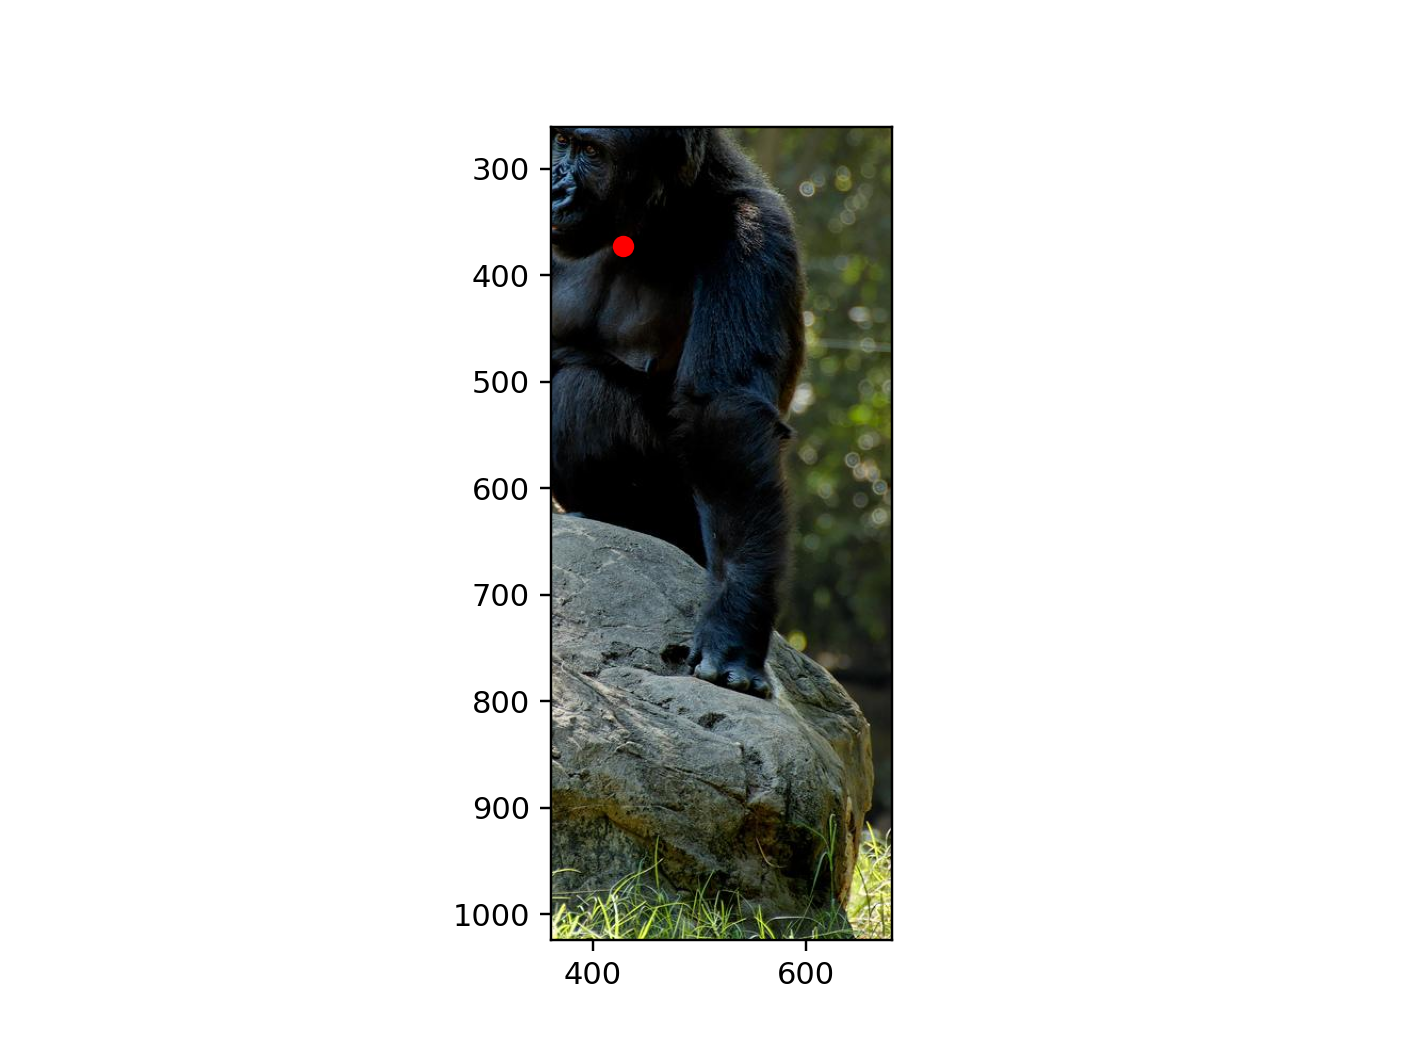

In [18]:
im = plt.imread(img_path)
fig = plt.figure()
ax = plt.axes(xlim=(min(x), im.shape[1]), ylim=(im.shape[0], min(y)))
im = ax.imshow(im)

point, = ax.plot([], [], marker='o', color='red')
#ax.axis([0, 682, 0, 1024])
# create a point in the axes
def animate(i):
    a,b = x[i], y[i]
    point.set_data(a,b)
    return point,
    
anim = FuncAnimation(fig, animate, frames=len(coords), interval=1)
plt.show()

In [17]:
fixs = []
fx, fy, i = cX[0], cY[0], 1
for x,y in zip(cX, cY):
    if abs(x-fx) < 20 and abs(y-fy)<20:
        fx = (fx*i + x)/float(i+1)
        fy = (fy*i + y)/float(i+1)
        i += 1
    else:
        fixs.append([fx,fy])
        fx, fy, i = x, y, 1

if i == 1:
    fixs.append([fx, fy])

NameError: name 'cX' is not defined

In [118]:
fixation, duration = ivt_mod(coords)

In [119]:
fy = [f[0] for f in fixation]
fx = [f[1] for f in fixation]

In [120]:
print(fixation)
print(duration)

[[513.45, 368.16], [326.5, 422], [439.6, 449], [285.89, 440], [286.82, 437.96], [381.33, 432], [445.87, 439]]
[212.5, 591.67, 179.17, 483.33, 45.83, 225.0, 362.5]


In [60]:
print(list(zip(fx,fy)))

[(368.1569868453709, 513.449411764706), (448.6218722402118, 439.6026046511629), (439.6008293321697, 285.888551724138), (436.32278481012656, 287.74399999999997), (439.3927688054707, 445.87255172413813), (439.3927688054707, 445.87255172413813)]


In [62]:
f = [[513.449411764706, 368.1569868453709], [326.5009577464792, 421.7301658049562], [439.6026046511629, 448.6218722402118], [285.888551724138, 439.6008293321697], [287.74399999999997, 436.32278481012656], [381.32977777777774, 432.03774027191736], [445.87255172413813, 439.3927688054707]]
fx = [a[1] for a in f]
fy = [a[0] for a in f]

<IPython.core.display.Javascript object>


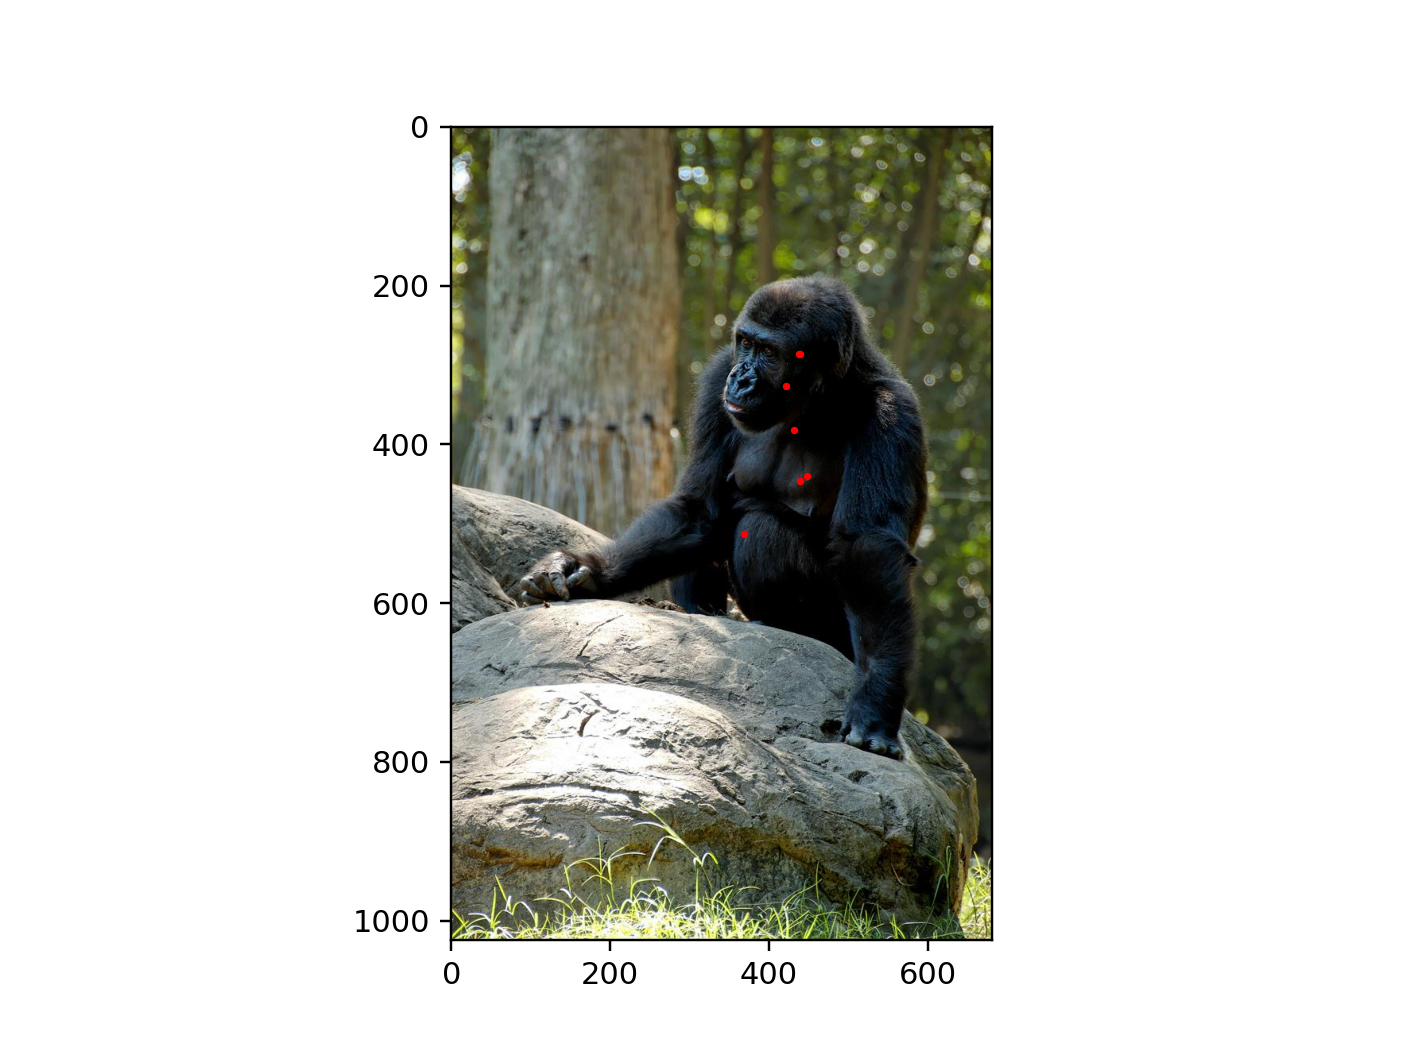

In [85]:
im = plt.imread(img_path)
fig = plt.figure()
ax = plt.axes(xlim=(0, im.shape[1]), ylim=(im.shape[0], 0))
im = ax.imshow(im)

ax.scatter(fx,fy, color='red', s=2)
plt.show()

In [99]:
fx = [f[0] for f in fixs]
fy = [f[1] for f in fixs]
fixs

[[368.1874391431351, 513.1778461538464],
 [421.8534566699122, 326.6609230769232],
 [448.6645569620252, 439.23199999999997],
 [437.87909769555364, 287.93394871794874],
 [432.01898734177206, 381.59360000000004]]

In [71]:
list(zip(cX,cY))

[(368.1874391431351, 513.1778461538464),
 (421.8534566699122, 326.6609230769232),
 (448.6645569620252, 439.23199999999997),
 (439.6463810451157, 285.97989743589744),
 (436.1118143459916, 289.888),
 (432.01898734177206, 381.59360000000004),
 (439.39240506329116, 446.0000000000002),
 (429.8971250804546, 432.7463050847459)]

<IPython.core.display.Javascript object>


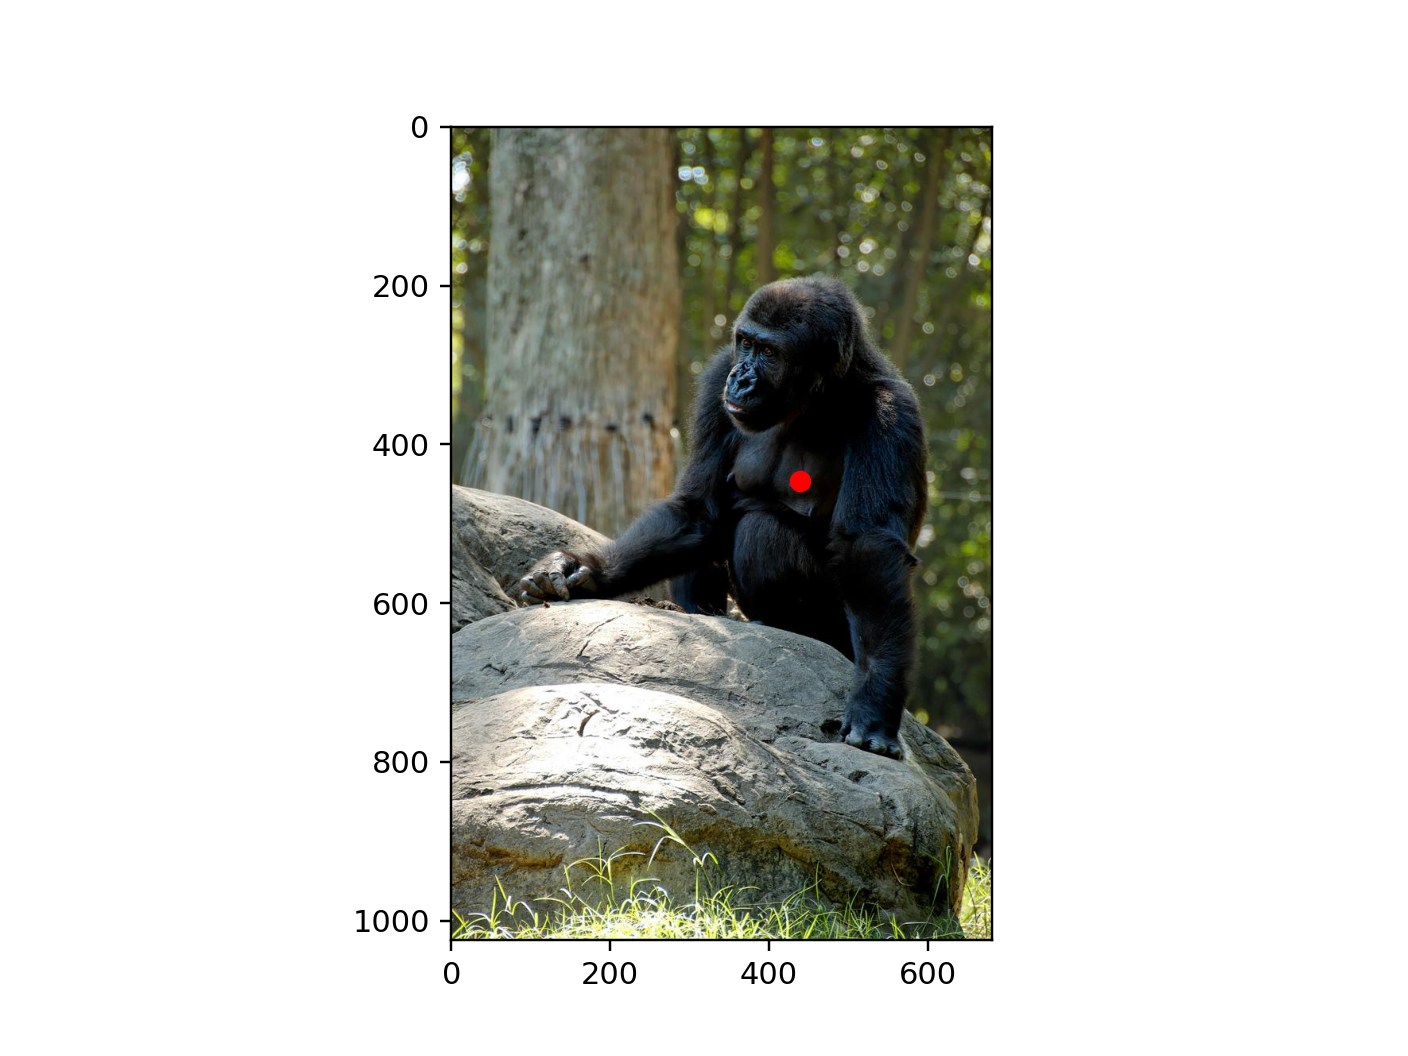

/home/abbas/.local/lib/python3.8/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [79]:
im = plt.imread(img_path)
fig = plt.figure()
ax = plt.axes(xlim=(0, im.shape[1]), ylim=(im.shape[0], 0))
im = ax.imshow(im)

point, = ax.plot([], [], marker='o', color='red')
#ax.axis([0, 682, 0, 1024])
# create a point in the axes
def animate(i):
    a,b = fx[i], fy[i]
    point.set_data(a,b)
    return point,
    
anim = FuncAnimation(fig, animate, frames=len(fx), interval=1000)
plt.show()

In [61]:
sfix, efix = fixation_detection(x,y) 

In [62]:
xC = np.array(efix)[:, 3]
yC = np.array(efix)[:, 4]

In [29]:
len(cX)

35

<IPython.core.display.Javascript object>


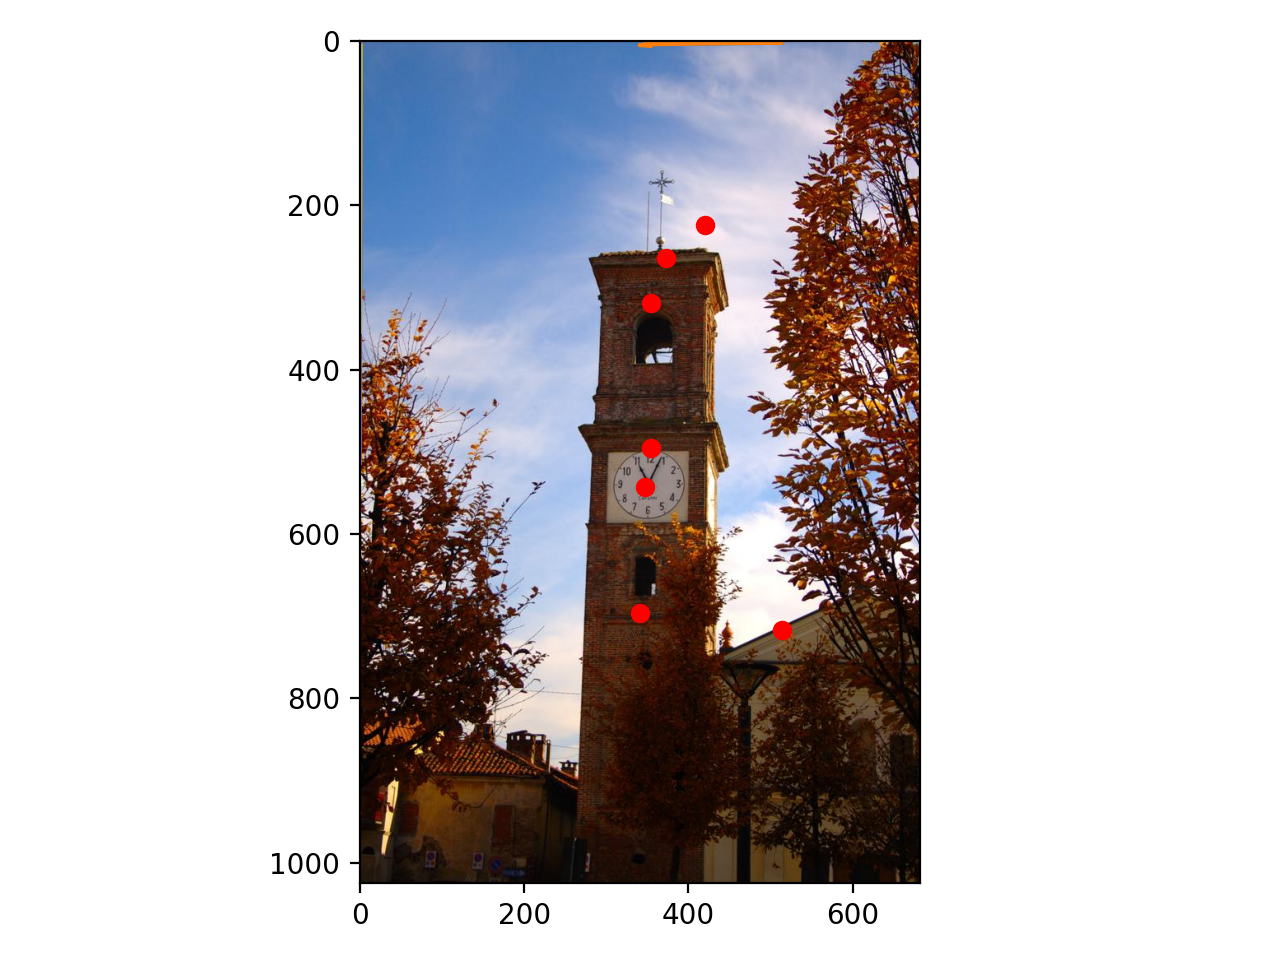

In [56]:
im = plt.imread(img_path)
fig = plt.figure()
ax = plt.axes(xlim=(0, im.shape[1]), ylim=(im.shape[0], 0))
im = ax.imshow(im)
x = [k[0] for k in kmeans.cluster_centers_]
y = [k[1] for k in kmeans.cluster_centers_]
ax.scatter(x,y, color='red')
plt.show()

<IPython.core.display.Javascript object>


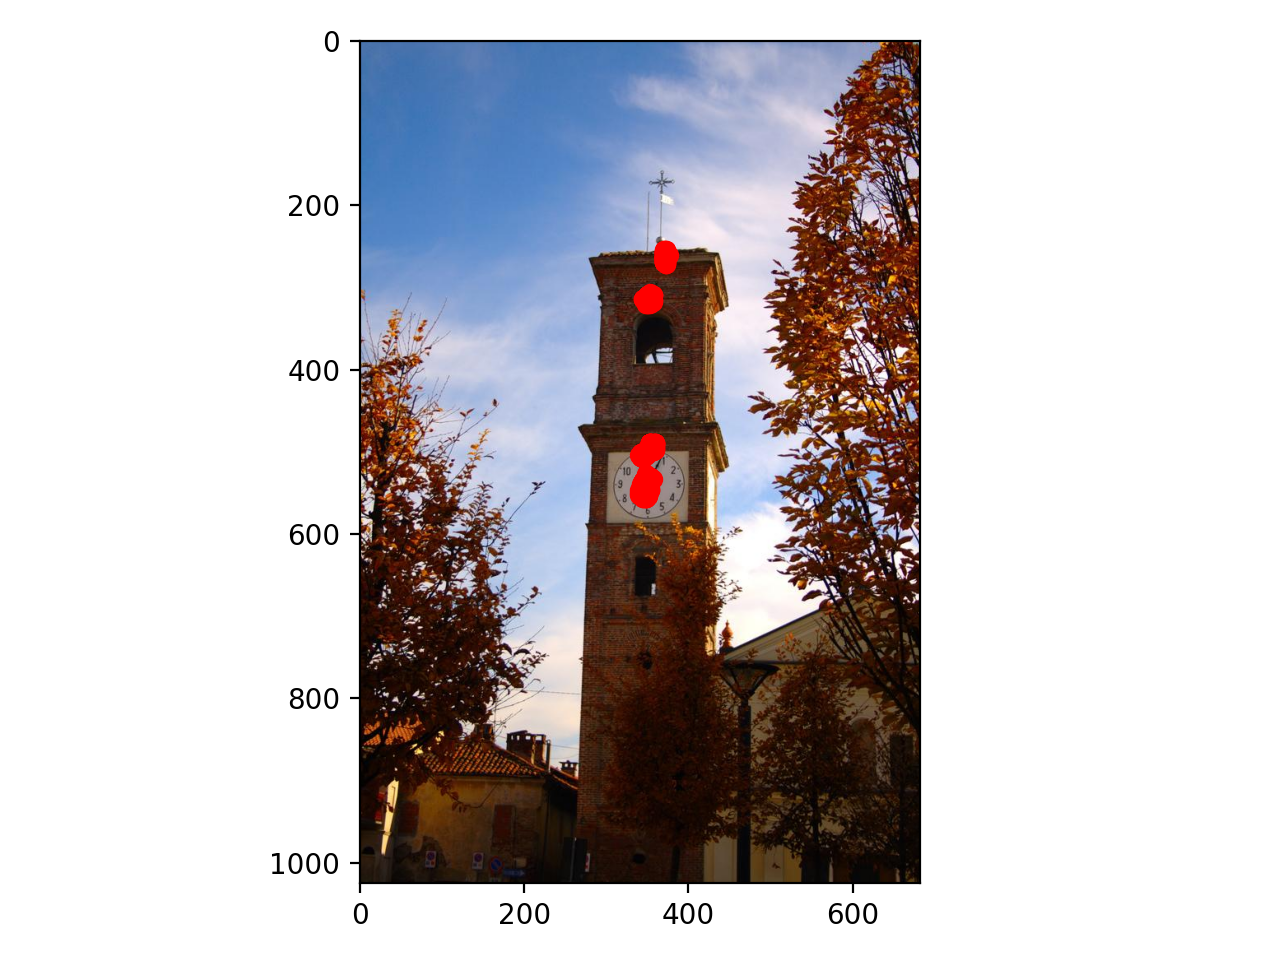

In [50]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10, min_samples=50)
dbscan.fit(coords)

im = plt.imread(img_path)
fig = plt.figure()
ax = plt.axes(xlim=(0, im.shape[1]), ylim=(im.shape[0], 0))
im = ax.imshow(im)
x = [k[0] for k in dbscan.components_]
y = [k[1] for k in dbscan.components_]
ax.scatter(x,y, color='red')
plt.show()

In [64]:
len(x)

687

<IPython.core.display.Javascript object>


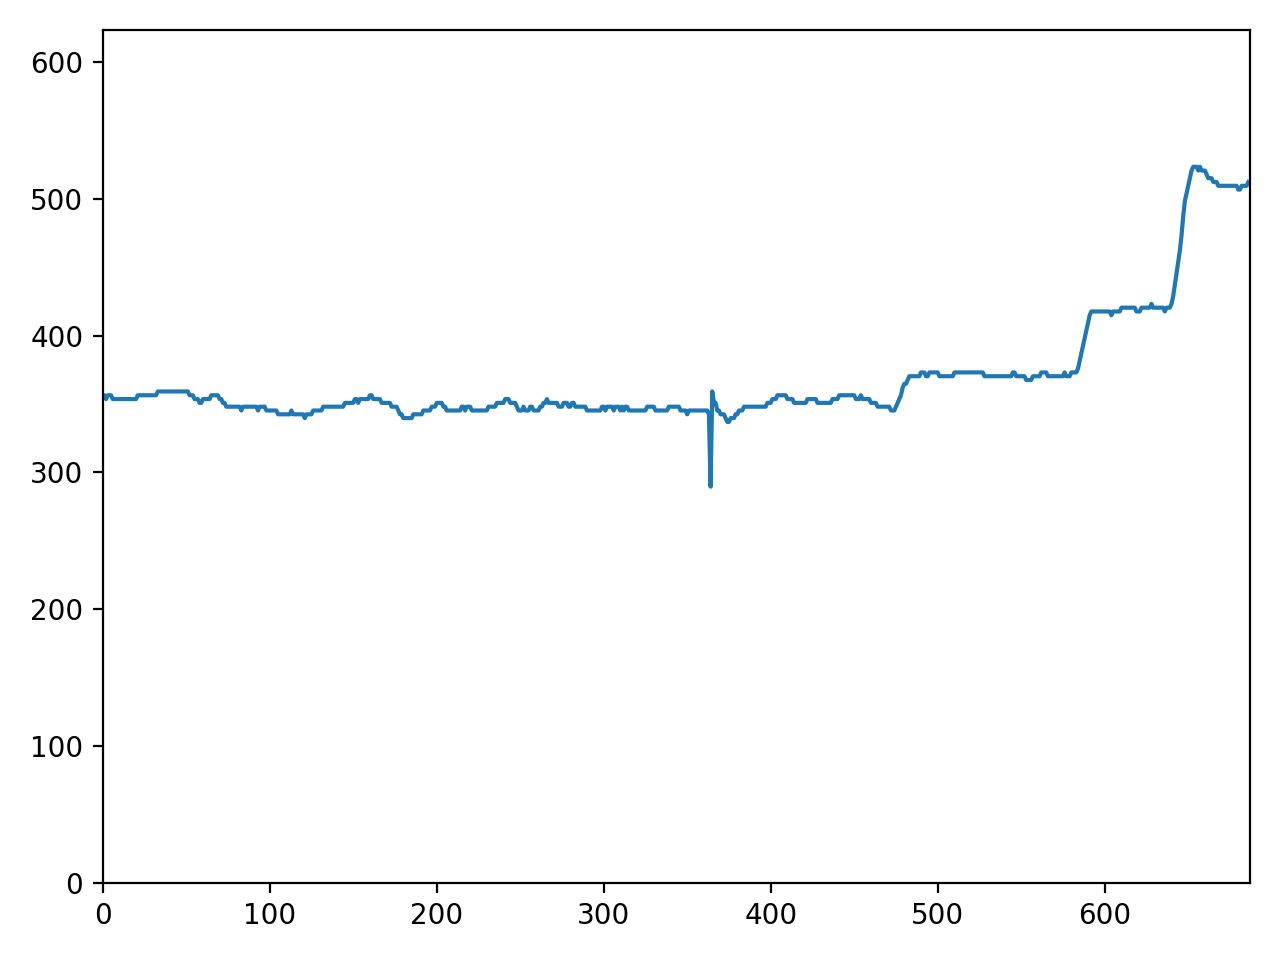

In [65]:
fig = plt.figure()
ax = plt.axes(xlim=(0, len(x)), ylim=(0, max(x)+100))
ax.plot(range(len(x)), x)
plt.show()

In [ ]:
# making a dictionary mapping each image to the viewings by different subjects
anno_dict = {s: [] for s in stimulis}
for _, viewing in view_dict.items():
    